- [X] Dataset => quel dataset (built-in pytorch) ? Quels sont les données ? (Normaliser les données) => pytorch.org/vision/stable/datasets.html
- [X] DataLoader
- [X] Model (Architecture) (Faire attention Input(taille de l'image)/output(Number of classes))
- [X] Entrainer votre modèle
- [X] Exporter en onnx

- [ ] Front/Style
- [ ] Back -> Créer une fonction (ONNXRUNTIME / ORT)

In [179]:
import torch
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import ConcatDataset
from torch.utils.tensorboard import SummaryWriter

## Téléchargement du dataset

In [180]:
# Importer Un dataset préfait

training_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

100%|██████████| 170M/170M [00:06<00:00, 25.2MB/s] 


In [181]:
# Normalisation des données

mean, std = 0, 0

combined_data = ConcatDataset([training_dataset, test_dataset])

for image, label in combined_data:
    image = image.view(32*32*3)
    mean += image.mean().sum()
    std += image.std().sum()

mean /= len(combined_data)
std /= len(combined_data)
print(f"Mean : {mean}")
print(f"Variance: {std}")

Mean : 0.4739009141921997
Variance: 0.2110767960548401


In [182]:

training_dataset_v2 = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize((mean), (std))])
)

test_dataset_v2 = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize((mean), (std))])
)

## Affichage random du dataset

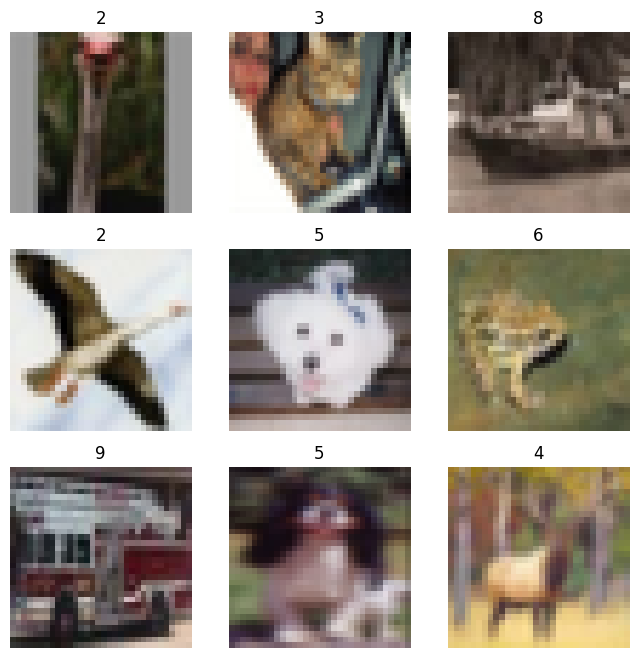

In [183]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")

    img = img.permute(1, 2, 0)
    plt.imshow(img, cmap="gray", interpolation="nearest")
plt.show()

## Liste des classes de CIFAR10

In [184]:
cifar10_classes = datasets.CIFAR10(root="data", train=True, download=True).classes

for i in cifar10_classes:
    print(i)


airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


## Création du dataloader, afin de traiter les données par lots

In [185]:
from torch.utils.data import DataLoader

# taille de chaque lot
batch_size = 64

#Shuffle pour mélanger les lots et éviter le par coeur
train_dataloader = DataLoader(training_dataset_v2, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset_v2, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"shape X : {X.shape}")
    print(f"y shape: {y.shape}")
    break

shape X : torch.Size([64, 3, 32, 32])
y shape: torch.Size([64])


In [186]:
train_features, train_labels = next(iter(train_dataloader))
train_features.shape

torch.Size([64, 3, 32, 32])

## Entrainement du model

In [187]:
# Vérification de l'accélération GPU sur Mac
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [188]:
# création du réseau de neuronnes
class MLP(nn.Module):
    def __init__(self, dims):
        super(MLP, self).__init__()
        self.fcs = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(len(dims)-1)]
        )
        self.act = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x) #1 * 28 * 28 -> 1 * 784 
        for layer in self.fcs:
            x  = layer(x)
            x = self.act(x)
        return x

In [189]:
# Les images de CIFAR10 sont de 32/32 pixels en rgb d'où le 3
input_dim = 32 * 32 * 3
model = MLP([input_dim, 128, 128, len(cifar10_classes)])

In [190]:
model

MLP(
  (fcs): ModuleList(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [191]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) 

In [192]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/cifar_experiment_1')
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    model.train()
    epoch_loss = 0
    correct = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss / len(dataloader), correct / len(dataloader.dataset) * 100

# Training loop with added graphing
def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model
        train_loss, accuracy = train_loop(dataloader_train, model, loss_fn, optimizer, batch_size)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': accuracy}, epoch)

        # Test the model
        test_loss, accuracy = test_loop(dataloader_test, model, loss_fn)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': accuracy}, epoch)

        print(f"Epoch {epoch+1}/{epochs} complete\n")

In [193]:
epochs = 4

## With Convolutional Neural Networks

In [194]:
model.to(device)

loss_fn = nn.CrossEntropyLoss().to(device) # Expect raw logits (!= probabilities)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) 

In [195]:
#in_channels => colors, out_chanels => nb of filters, kernel_size impair, padding => don't lose information in border

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), #1 * 28 * 28 -> #32 * 28 * 28
            nn.ReLU(),
            nn.Dropout(0, 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), #32 * 28 * 28 -> 64 * 28 * 28
            nn.ReLU(),
            nn.Dropout(0, 2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), #64 * 28 *28 -> 64 * 14 * 14
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 64 x 16 x 16 -> 128 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    
        )
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0, 2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0, 2),
            nn.Linear(128, 10),
        )
    
    def forward(self, x):
        x = self.conv_stack(x)
        x = self.mlp(x)
        return x

In [196]:
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3) 

In [197]:
train_and_test(train_dataloader, test_dataloader, cnn, loss_fn, optimizer, epochs, batch_size)

Epoch 1/4
Epoch 1/4 complete

Epoch 2/4
Epoch 2/4 complete

Epoch 3/4
Epoch 3/4 complete

Epoch 4/4
Epoch 4/4 complete



In [198]:
cnn.to('cpu')
torch_input = torch.randn(1, 3, 32, 32)
cnn_program = torch.onnx.export(
    cnn,
    torch_input,
    "model.onnx",
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    opster_version=11,
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        "input" : {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

Exported graph: graph(%input : Float(*, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu),
      %conv_stack.0.weight : Float(32, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_stack.0.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.3.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_stack.3.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.6.weight : Float(64, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.6.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.6.running_mean : Float(64, strides=[1], requires_grad=0, device=cpu),
      %conv_stack.6.running_var : Float(64, strides=[1], requires_grad=0, device=cpu),
      %conv_stack.8.weight : Float(128, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_stack.8.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
    

In [199]:
import onnxruntime

onnx_input = [torch_input]
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")

ort_session = onnxruntime.InferenceSession("model.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

# onnxruntime returns a list of outputs
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]

Input length: 1
Sample input: [tensor([[[[-8.7572e-04,  1.1453e+00,  1.3975e+00,  ..., -1.7733e+00,
           -3.1892e-01, -4.7324e-01],
          [-2.1536e+00,  2.3760e+00, -4.1937e-02,  ...,  6.3129e-01,
           -4.3388e-01, -9.7494e-01],
          [ 1.8479e-01,  1.6617e+00,  5.4282e-01,  ..., -6.9116e-02,
           -4.4635e-01, -1.1009e+00],
          ...,
          [-4.4192e-01, -9.7724e-01,  9.8900e-01,  ..., -1.1791e+00,
            8.8592e-01,  1.5493e+00],
          [-1.5913e+00,  6.8844e-02, -1.2348e+00,  ..., -8.1368e-01,
           -8.0467e-01,  7.0620e-01],
          [-2.5071e-01,  3.9302e-01, -7.1796e-01,  ...,  8.3079e-01,
            4.9455e-02, -5.0146e-01]],

         [[ 2.0788e-01,  1.4299e+00, -6.7693e-01,  ...,  9.2884e-01,
            9.4297e-01, -5.3412e-01],
          [ 6.9742e-01, -9.0540e-01, -2.6005e+00,  ..., -1.1708e+00,
           -1.1559e+00, -3.0275e-01],
          [ 5.4541e-01, -1.4094e+00, -5.9611e-02,  ..., -4.3972e-01,
            9.5282e-01,  5.